In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rand
plt.rcParams['figure.figsize'] = (9,7)
%matplotlib qt
from matplotlib.animation import FFMpegWriter
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib.image as mpimg

### Ant colony simulation

This is the first draft of a project that aims to simulate the movement of ants in search of food. While it succeeds to depict the randomness of the ant's movement, I have not thoroughly tested if the probability implementation is robust.

<div>
<img src=attachment:69365ba8-de82-4709-ac8e-d83b2c795d57.png width="150"/>
</div>
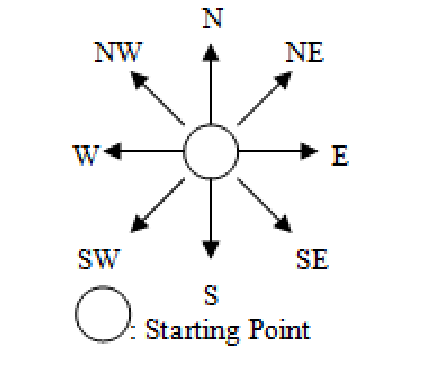

In [2]:
nants = 10 #number of ants
N = 50 # xlen and ylen
l = 1 #step size of ant
bound = 7 #border for placement of food and nest
scale = 2

In [3]:
dir_angle = {'n': 0, 's': 180, 'w':90, 'e': 270, 'ne':270+45, 'se':180+45, 'sw': 90+45, 'nw': 45}

In [4]:
class Ant:
    def __init__(self):
        self.x = nestx
        self.y = nesty
        self.state = 'nest'
        self.poss_states = np.array(['n', 's', 'e', 'w', 'ne', 'nw', 'sw', 'se'])
        self.xc = [self.x]
        self.yc = [self.y]
        self.covered = [[self.x, self.y]]
        self.step = l
        self.alert = False
    def possible_states(self):
        usual = self.poss_states
        states = []
        if self.x == 0:
            states.append(usual[['e' in i for i in usual]])
        if self.x == N-1:
            states.append(usual[['w' in i for i in usual]])
        if self.y == 0:
            states.append(usual[['n' in i for i in usual]])
        if self.y == N-1:
            states.append(usual[['s' in i for i in usual]])
        if self.x < 0 or self.x > N-1 or self.y < 0 or self.y > N-1:
            self.remove()
        else:
            states = usual
            
    def remove(self):
        self.x = nestx
        self.y = nesty
            
        '''if self.x < 0:
            usual = usual[['e' in i for i in usual]]
        if self.x > N-1:
            usual = usual[['w' in i for i in usual]]
        if self.y < 0:
            usual = usual[['n' in i for i in usual]]
        if self.y > N-1:
            usual = usual[['s' in i for i in usual]]'''
            
        self.poss_states = np.array(states).flatten()
        
    def make_state_dict(self):
        self.possible_states()
        state_dict = {'n':[self.x, self.y + self.step], 
                      's':[self.x, self.y-self.step], 
                      'e':[self.x+self.step, self.y], 
                      'w':[self.x-self.step, self.y],
                      'ne':[self.x+self.step, self.y+self.step],
                      'nw':[self.x-self.step, self.y+self.step],
                      'se':[self.x+self.step, self.y-self.step],
                      'sw':[self.x-self.step, self.y-self.step]}
        
        self.prob_array = []
        
        if len(self.poss_states) < 8:
            state_dict_short = {}
            for direction in self.poss_states:
                state_dict_short[direction] = state_dict[direction]
                x, y = state_dict_short[direction][0], state_dict_short[direction][1]
                if x>=0 and x<=N-1 and y>=0 and y<=N-1:
                    self.prob_array.append(prob_mat[x][y])
                else:
                    self.prob_array.append(1e-5)
            return state_dict_short
        for d in self.poss_states:
            x, y = state_dict[d][0], state_dict[d][1]
            if x>=0 and x<=N-1 and y>=0 and y<=N-1:
                self.prob_array.append(prob_mat[x][y])
            else:
                self.prob_array.append(1e-5)
                                                               
        return state_dict
    
    def move_ant(self):
        # updates possible directions based on current position        
        
        
        state_dict = self.make_state_dict()
        # picks a random direction
        if sum(self.prob_array)!=1:
            self.prob_array = np.array(self.prob_array)/sum(self.prob_array)
        #debugging
        if len(np.array(list(state_dict)))==0:
            print(self.x, self.y, self.dir)
        direction = np.random.choice(np.array(list(state_dict)), p = self.prob_array)
        
        self.dir = direction
        prevst = self.state
        
        pos = state_dict[direction]
        self.x = pos[0]
        self.y = pos[1]
        
        if self.x>=0 and self.x<=N-1 and self.y>=0 and self.y<=N-1:
            space_mat[self.y][self.x] += 1
        if abs(self.x-foodx) <= 2 and abs(self.y-foody) <= 2:
            self.state = 'food'
            self.alert = True
            
        self.xc.append(pos[0])
        self.yc.append(pos[1])
        self.covered.append(pos)
        self.update_spacearr()
        self.update_foodarr()
        
        if self.alert:
            self.update_prob()
        
        
    def update_spacearr(self):
        x = self.x
        y = self.y
        dist = np.sqrt((x - nestx)**2 + (y - nesty)**2)
        if x>=0 and x<=N-1 and y>=0 and y<=N-1:
            if dist_mat[x][y] > dist or dist_mat[x][y] == 0:
                dist_mat[x][y] = dist
                
    def update_foodarr(self):
        x = self.x
        y = self.y
        dist = np.sqrt((x - foodx)**2 + (y - foody)**2)
        if x>=0 and x<=N-1 and y>=0 and y<=N-1:
            prob_mat_s[y][x] = 1-dist
            
    def update_prob(self):
        for i in self.covered:
            x = i[0]
            y = i[1]
            dist = np.sqrt((x - foodx)**2 + (y - foody)**2)
            prob_mat[x][y] += dist
        self.alert=False

In [5]:
# PLOTS ANT PATH AND FOOD CLOSENESS
metadata = dict(title='Ant random moving', artist='Matplotlib',comment='eps 109 project')
writer = FFMpegWriter(fps=4, metadata=metadata)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,6))

dist_mat = np.zeros((N,N))

prob_mat = np.ones((N,N))*1/8

space_mat = np.zeros((N,N))
prob_mat_s = np.ones((N,N))*1/8
foodx, foody = rand.randint(bound,N-bound), rand.randint(bound,N-bound)
nestx, nesty = rand.randint(bound,N-bound), rand.randint(bound,N-bound)
space_mat[nesty][nestx] = 1
bg = plt.imread('background.jpg')
anthill = plt.imread('download.png')
food = plt.imread('download.jfif')

# add ant hill
h = OffsetImage(anthill, zoom = 0.1)
xy = [nestx, nesty]
ab_ah = AnnotationBbox(h, xy)

# add food
f = OffsetImage(food, zoom = 0.1)
xy = [foodx, foody]
ab_f = AnnotationBbox(f, xy)

with writer.saving(fig, "alert.mp4", dpi=200):
    ants = [Ant() for i in range(nants)]
    
    for i in range(50):
        ax1.imshow(bg, extent = [0, N, 0, N], aspect='auto')
        
        ax1.add_artist(ab_ah)
        ax1.add_artist(ab_f)
        
        for ant in ants:
            ant.move_ant()

            if ant.state == 'food':
                if ant.alert:
                    print('alerted')
                    ax1.scatter(ant.x, ant.y, marker = (3,0,dir_angle[ant.dir]), color= 'g', s = 60)
                else:
                    ax1.scatter(ant.x, ant.y, marker = (3,0,dir_angle[ant.dir]), color= 'r', s = 30)
                line, = ax1.plot(ant.xc, ant.yc, 'y--', lw=2, alpha = 0.8)
                line.set_label('Food found')     
                
            else:
                #ax1.plot(ant.xc, ant.yc, 'k--', lw=2)
                line, = ax1.plot(ant.xc, ant.yc, 'k--', lw=2, alpha = 0.6)
                line.set_label('Food search')
                ax1.scatter(ant.x, ant.y, marker = (3,0,dir_angle[ant.dir]), color= 'r', s = 30)
    
            #ax1.annotate(f'{ants.index(ant)}th Ant', (ant.x, ant.y))
            ax2.imshow(prob_mat_s, cmap = 'hot')
            ax2.imshow(bg, extent = [0, N, 0, N], aspect='auto', alpha = 0.5)
            

            ax2.set_xlim(0,N)
            ax2.set_ylim(0,N)
            ax2.set_title('Closeness to food')
            ax1.set_xlim(0,N)
            ax1.set_ylim(0,N);
            ax1.set_title('Ant Path')
            ax1.axis('off')
            ax2.axis('off')
            
            
        ax1.legend()    
        plt.show();
        plt.draw();
        writer.grab_frame();
        plt.pause(0.1);
        ax1.clear()
        ax2.clear()
        
        

In [6]:
# PLOTS ANT PATH AND SPACE TRAMPLED
metadata = dict(title='Ant random moving', artist='Matplotlib',comment='eps 109 project')
writer = FFMpegWriter(fps=4, metadata=metadata)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,6))

dist_mat = np.zeros((N,N))
prob_mat = np.ones((N,N))*1/8
space_mat = np.zeros((N,N))
prob_mat_s = np.ones((N,N))*1/8
foodx, foody = rand.randint(bound,N-bound), rand.randint(bound,N-bound)
nestx, nesty = rand.randint(bound,N-bound), rand.randint(bound,N-bound)
space_mat[nesty][nestx] = 1
bg = plt.imread('background.jpg')
anthill = plt.imread('download.png')
food = plt.imread('download.jfif')

# add ant hill
h = OffsetImage(anthill, zoom = 0.1)
xy = [nestx, nesty]
ab_ah = AnnotationBbox(h, xy)#, xybox = (30., -30.), boxcoords = 'offset points')

# add food
f = OffsetImage(food, zoom = 0.1)
xy = [foodx, foody]
ab_f = AnnotationBbox(f, xy)#, xybox = (30., -30.), boxcoords = 'offset points')

with writer.saving(fig, "test.mp4", dpi=200):
    ants = [Ant() for i in range(10)]
    
    for i in range(200):
        ax1.imshow(bg, extent = [0, N, 0, N], aspect='auto')
        ax1.add_artist(ab_ah)
        ax1.add_artist(ab_f)
        #ax1.plot(foodx, foody, 'g*', label = 'food', markersize = 20)
        #ax1.plot(nestx, nesty, 'bs', label = 'nest' , markersize = 15)
        
        #plt.clf()
        #plt.plot(nestx, nesty, 'ro', label = 'nest')
        
        for ant in ants:
            ant.move_ant()
            if ant.state == 'food':
                line, = ax1.plot(ant.xc, ant.yc, 'y--', lw=2, alpha = 0.8)
                line.set_label('Food found')                
            else:
                #ax1.plot(ant.xc, ant.yc, 'k--', lw=2)
                line, = ax1.plot(ant.xc, ant.yc, 'k--', lw=2, alpha = 0.5)
                line.set_label('Food search')
            ax1.scatter(ant.x, ant.y, marker = (3,0,dir_angle[ant.dir]), color= 'r', s = 30)
    
            #ax1.annotate(f'{ants.index(ant)}th Ant', (ant.x, ant.y))
            
            ax2.imshow(space_mat, cmap = 'YlOrBr')
            ax2.set_xlim(0,N)
            ax2.set_ylim(0,N)
            ax2.set_title('Space trampled')
            ax1.set_xlim(0,N)
            ax1.set_ylim(0,N);
            ax1.set_title('Ant Path')
            ax1.axis('off')
            ax2.axis('off')
            
            
        ax1.legend()    
        plt.show();
        plt.draw();
        writer.grab_frame();
        plt.pause(0.1);
        ax1.clear()
        ax2.clear()
        
        